In [1]:
# Import appropriate modules
import pandas as pd
import datetime
import numpy as np
import yfinance as yf
from pathlib import Path
from datetime import datetime
import hvplot
import hvplot.pandas
from fbprophet import Prophet
# import plot change point function
from fbprophet.plot import add_changepoints_to_plot


In [2]:
start_data_date = '2006-07-02'
end_data_date = '2021-10-02'

In [3]:
# Define function to retrieve ticker daily return data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_return(ticker = 'spy', start_date = start_data_date, end_date = end_data_date):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        price_df = yahoo_data.history(start=start_date, end=end_date).Close.pct_change()
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [4]:
# Define function to retrieve ticker daily close data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_close(ticker = 'spy', start_date = start_data_date, end_date = end_data_date):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and save the Close data
        price_df = yahoo_data.history(start=start_date, end=end_date).Close
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [5]:
# Define function to retrieve ticker daily return data from yahoo using ticker, start date and end date
def retrieve_yahoo_data_volume(ticker = 'spy', start_date = start_data_date, end_date = end_data_date):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        price_df = yahoo_data.history(start=start_date, end=end_date).Volume
        price_df.name = ticker
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [6]:
# Define function to retrieve ticker daily return data from yahoo using ticker, start date and end date
def retrieve_yahoo_put_options_volume(ticker = 'spy', date = '2007-07-01'):
    try:
        # get data based on ticker
        yahoo_data = yf.Ticker(ticker)
        print(f"Processing Ticker {ticker}")
        # select data using start date and end data and calculate the daily return
        opts = yahoo_data.option_chain()
        price_df = opts.puts
        price_df.name = ticker
        price_df = price_df.volume
        # if no data retrieved raise exception
        if price_df.shape[0] == 0:
            raise Exception("No Prices.")
        return price_df
    # handle exception
    except Exception as ex:
        print(f"Sorry, Data not available for '{ticker}': Exception is {ex}")

In [7]:
# Set up the variable related to tickers and tickers data
ticker_data_dict = {}
ticker_list = ["^VIX", "VXX"]

# Retrieve Tickers
def retrieve_tickers(ticker_data_dict, ticker_list):
    for ticker in ticker_list:
        ticker_data = retrieve_yahoo_data_return(ticker)
        ticker_data_dict[ticker] = ticker_data
        
    return ticker_data_dict
        
ticker_data_dict = retrieve_tickers(ticker_data_dict, ticker_list)
ticker_data_df = pd.DataFrame(ticker_data_dict)
# ticker_data_df = ticker_data_df.dropna()
# Display the ticker data related data frame
ticker_data_df

Processing Ticker ^VIX
Processing Ticker VXX


^VIX       VXX
Date                          
2006-07-03       NaN       NaN
2006-07-05  0.084291       NaN
2006-07-06 -0.035336       NaN
2006-07-07  0.023443       NaN
2006-07-10  0.003579       NaN
...              ...       ...
2021-09-27  0.056901  0.009764
2021-09-28  0.239339  0.104351
2021-09-29 -0.029677  0.014593
2021-09-30  0.025709  0.000719
2021-10-01 -0.088159 -0.036292

[3840 rows x 2 columns]

In [8]:
# check the correlation between various tickers
ticker_data_df.corr()

^VIX       VXX
^VIX  1.000000  0.886507
VXX   0.886507  1.000000

In [9]:
(1+ticker_data_df[["^VIX", "VXX"]]).cumprod().hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [10]:
vix_data_df = ticker_data_df.drop(columns="VXX")
vix_data_df = vix_data_df.reset_index()
vix_data_df.columns = ['ds', 'y']
vix_data_df

ds         y
0    2006-07-03       NaN
1    2006-07-05  0.084291
2    2006-07-06 -0.035336
3    2006-07-07  0.023443
4    2006-07-10  0.003579
...         ...       ...
3835 2021-09-27  0.056901
3836 2021-09-28  0.239339
3837 2021-09-29 -0.029677
3838 2021-09-30  0.025709
3839 2021-10-01 -0.088159

[3840 rows x 2 columns]

In [11]:
vix_data_df = vix_data_df.sort_values(by=['ds'])

# Use hvPlot to visually inspect the price data
vix_data_df.hvplot(x='ds', y ='y')

:Curve   [ds]   (y)

In [12]:
model = Prophet()
model

In [13]:
# Fit the time-series model.
model.fit(vix_data_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days, or 1000/24 = 40)
future_trends = model.make_future_dataframe(periods=1000, freq='H')
future_trends

ds
0    2006-07-03 00:00:00
1    2006-07-05 00:00:00
2    2006-07-06 00:00:00
3    2006-07-07 00:00:00
4    2006-07-10 00:00:00
...                  ...
4835 2021-11-11 12:00:00
4836 2021-11-11 13:00:00
4837 2021-11-11 14:00:00
4838 2021-11-11 15:00:00
4839 2021-11-11 16:00:00

[4840 rows x 1 columns]

In [15]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends = model.predict(future_trends)
forecast_trends

ds     trend  yhat_lower  yhat_upper  trend_lower  \
0    2006-07-03 00:00:00  0.016757   -0.090137    0.117210     0.016757   
1    2006-07-05 00:00:00  0.016757   -0.119146    0.091078     0.016757   
2    2006-07-06 00:00:00  0.016756   -0.103418    0.099182     0.016756   
3    2006-07-07 00:00:00  0.016756   -0.124336    0.079221     0.016756   
4    2006-07-10 00:00:00  0.016755   -0.094782    0.108151     0.016755   
...                  ...       ...         ...         ...          ...   
4835 2021-11-11 12:00:00  0.017919   -0.115019    0.093911     0.017919   
4836 2021-11-11 13:00:00  0.017919   -0.115918    0.093683     0.017919   
4837 2021-11-11 14:00:00  0.017919   -0.116281    0.089952     0.017919   
4838 2021-11-11 15:00:00  0.017919   -0.116064    0.093981     0.017919   
4839 2021-11-11 16:00:00  0.017919   -0.122496    0.088163     0.017919   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0        0.016757       -0.005038             -0.005038             -0.005038   
1        0.016757       -0.027021             -0.027021             -0.027021   
2        0.016756       -0.022280             -0.022280             -0.022280   
3        0.016756       -0.033744             -0.033744             -0.033744   
4        0.016755       -0.004987             -0.004987             -0.004987   
...           ...             ...                   ...                   ...   
4835     0.017919       -0.028416             -0.028416             -0.028416   
4836     0.017919       -0.029190             -0.029190             -0.029190   
4837     0.017919       -0.029852             -0.029852             -0.029852   
4838     0.017919       -0.030388             -0.030388             -0.030388   
4839     0.017919       -0.030784             -0.030784             -0.030784   

        weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0     0.003391      0.003391      0.003391 -0.008429     -0.008429   
1    -0.017930     -0.017930     -0.017930 -0.009091     -0.009091   
2    -0.013062     -0.013062     -0.013062 -0.009218     -0.009218   
3    -0.024537     -0.024537     -0.024537 -0.009207     -0.009207   
4     0.003391      0.003391      0.003391 -0.008378     -0.008378   
...        ...           ...           ...       ...           ...   
4835 -0.025336     -0.025336     -0.025336 -0.003080     -0.003080   
4836 -0.026096     -0.026096     -0.026096 -0.003095     -0.003095   
4837 -0.026743     -0.026743     -0.026743 -0.003109     -0.003109   
4838 -0.027264     -0.027264     -0.027264 -0.003124     -0.003124   
4839 -0.027646     -0.027646     -0.027646 -0.003138     -0.003138   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0        -0.008429                   0.0                         0.0   
1        -0.009091                   0.0                         0.0   
2        -0.009218                   0.0                         0.0   
3        -0.009207                   0.0                         0.0   
4        -0.008378                   0.0                         0.0   
...            ...                   ...                         ...   
4835     -0.003080                   0.0                         0.0   
4836     -0.003095                   0.0                         0.0   
4837     -0.003109                   0.0                         0.0   
4838     -0.003124                   0.0                         0.0   
4839     -0.003138                   0.0                         0.0   

      multiplicative_terms_upper      yhat  
0                            0.0  0.011719  
1                            0.0 -0.010264  
2                            0.0 -0.005524  
3                            0.0 -0.016988  
4                            0.0  0.011768  
...                          ...       ...  
4835                         0.0 -0.010497  
4836                         0.0 -0.011271  
4837                         0.0 -0.0

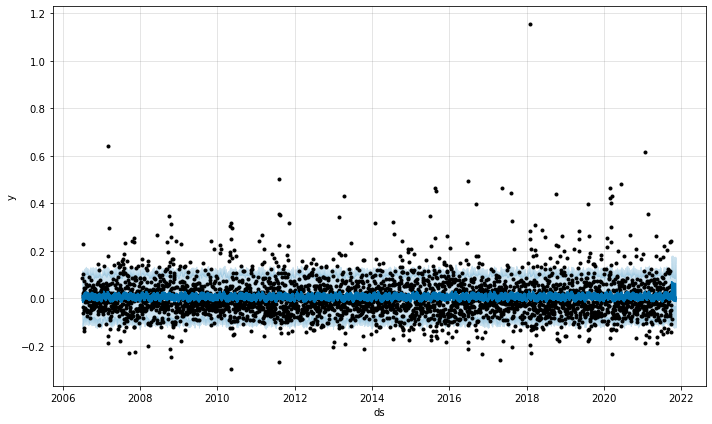

In [16]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends = model.plot(forecast_trends)

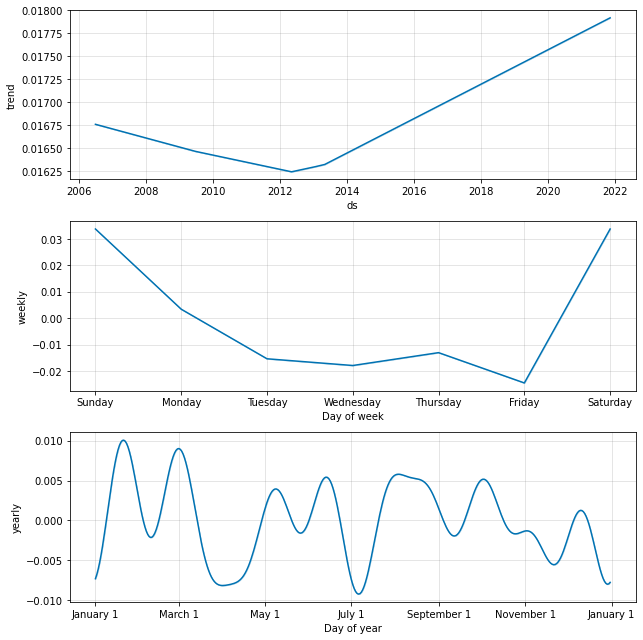

In [17]:
# Use the plot_components function to visualize the forecast results.
figures = model.plot_components(forecast_trends)

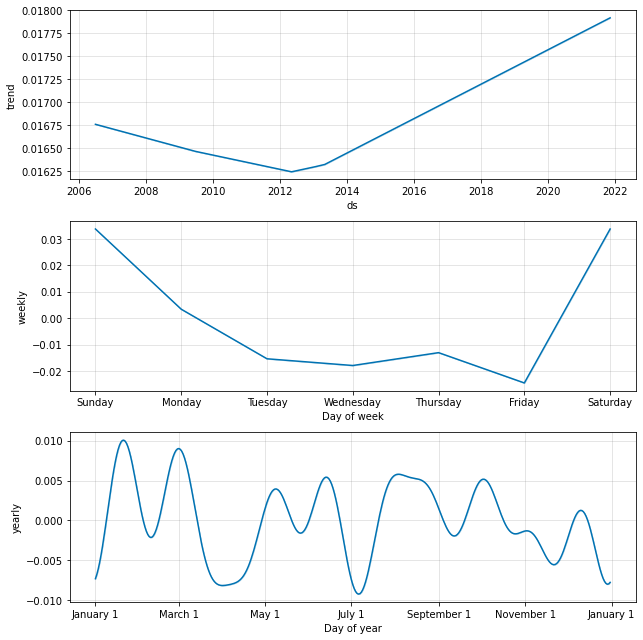

In [18]:
model.plot_components(forecast_trends).savefig('vix_returns_seasonality.png')

In [19]:
vix_cum_prod_df = (1+ticker_data_df[["^VIX"]]).cumprod()
vix_cum_prod_df

^VIX
Date                
2006-07-03       NaN
2006-07-05  1.084291
2006-07-06  1.045977
2006-07-07  1.070498
2006-07-10  1.074330
...              ...
2021-09-27  1.437548
2021-09-28  1.781609
2021-09-29  1.728736
2021-09-30  1.773180
2021-10-01  1.616858

[3840 rows x 1 columns]

In [20]:
vix_cum_prod_df = vix_cum_prod_df.reset_index()
vix_cum_prod_df.columns = ['ds', 'y']
vix_cum_prod_df

ds         y
0    2006-07-03       NaN
1    2006-07-05  1.084291
2    2006-07-06  1.045977
3    2006-07-07  1.070498
4    2006-07-10  1.074330
...         ...       ...
3835 2021-09-27  1.437548
3836 2021-09-28  1.781609
3837 2021-09-29  1.728736
3838 2021-09-30  1.773180
3839 2021-10-01  1.616858

[3840 rows x 2 columns]

In [21]:
vix_cum_prod_df = vix_cum_prod_df.sort_values(by=['ds'])

# Use hvPlot to visually inspect the price data
vix_cum_prod_df.hvplot(x='ds', y ='y')

:Curve   [ds]   (y)

In [22]:
model_cum_prod = Prophet()
model_cum_prod

In [23]:
# Fit the time-series model.
model_cum_prod.fit(vix_cum_prod_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days, or 1000/24 = 40)
future_trends_cum_prod = model_cum_prod.make_future_dataframe(periods=1000, freq='H')
future_trends_cum_prod

ds
0    2006-07-03 00:00:00
1    2006-07-05 00:00:00
2    2006-07-06 00:00:00
3    2006-07-07 00:00:00
4    2006-07-10 00:00:00
...                  ...
4835 2021-11-11 12:00:00
4836 2021-11-11 13:00:00
4837 2021-11-11 14:00:00
4838 2021-11-11 15:00:00
4839 2021-11-11 16:00:00

[4840 rows x 1 columns]

In [25]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends_cum_prod = model_cum_prod.predict(future_trends_cum_prod)
forecast_trends_cum_prod

ds     trend  yhat_lower  yhat_upper  trend_lower  \
0    2006-07-03 00:00:00  0.685432   -0.100247    1.173901     0.685432   
1    2006-07-05 00:00:00  0.689628   -0.165964    1.148086     0.689628   
2    2006-07-06 00:00:00  0.691726   -0.136559    1.159774     0.691726   
3    2006-07-07 00:00:00  0.693824   -0.112140    1.115182     0.693824   
4    2006-07-10 00:00:00  0.700118   -0.124789    1.132670     0.700118   
...                  ...       ...         ...         ...          ...   
4835 2021-11-11 12:00:00  2.085362    1.498572    2.712840     2.085362   
4836 2021-11-11 13:00:00  2.085389    1.484424    2.776296     2.085389   
4837 2021-11-11 14:00:00  2.085417    1.451229    2.740476     2.085417   
4838 2021-11-11 15:00:00  2.085444    1.472153    2.725356     2.085444   
4839 2021-11-11 16:00:00  2.085472    1.456141    2.756589     2.085472   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0        0.685432       -0.151726             -0.151726             -0.151726   
1        0.689628       -0.178348             -0.178348             -0.178348   
2        0.691726       -0.181541             -0.181541             -0.181541   
3        0.693824       -0.199921             -0.199921             -0.199921   
4        0.700118       -0.192568             -0.192568             -0.192568   
...           ...             ...                   ...                   ...   
4835     2.085362        0.038342              0.038342              0.038342   
4836     2.085389        0.036671              0.036671              0.036671   
4837     2.085417        0.035373              0.035373              0.035373   
4838     2.085444        0.034501              0.034501              0.034501   
4839     2.085472        0.034107              0.034107              0.034107   

        weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0    -0.063168     -0.063168     -0.063168 -0.088558     -0.088558   
1    -0.078650     -0.078650     -0.078650 -0.099698     -0.099698   
2    -0.075953     -0.075953     -0.075953 -0.105588     -0.105588   
3    -0.088335     -0.088335     -0.088335 -0.111586     -0.111586   
4    -0.063168     -0.063168     -0.063168 -0.129400     -0.129400   
...        ...           ...           ...       ...           ...   
4835 -0.104875     -0.104875     -0.104875  0.143217      0.143217   
4836 -0.106429     -0.106429     -0.106429  0.143100      0.143100   
4837 -0.107609     -0.107609     -0.107609  0.142982      0.142982   
4838 -0.108363     -0.108363     -0.108363  0.142864      0.142864   
4839 -0.108639     -0.108639     -0.108639  0.142746      0.142746   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0        -0.088558                   0.0                         0.0   
1        -0.099698                   0.0                         0.0   
2        -0.105588                   0.0                         0.0   
3        -0.111586                   0.0                         0.0   
4        -0.129400                   0.0                         0.0   
...            ...                   ...                         ...   
4835      0.143217                   0.0                         0.0   
4836      0.143100                   0.0                         0.0   
4837      0.142982                   0.0                         0.0   
4838      0.142864                   0.0                         0.0   
4839      0.142746                   0.0                         0.0   

      multiplicative_terms_upper      yhat  
0                            0.0  0.533706  
1                            0.0  0.511280  
2                            0.0  0.510185  
3                            0.0  0.493903  
4                            0.0  0.507550  
...                          ...       ...  
4835                         0.0  2.123704  
4836                         0.0  2.122061  
4837                         0.0  2.1

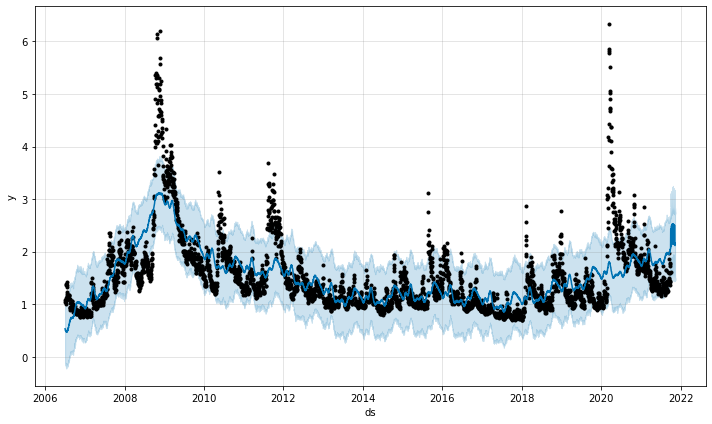

In [26]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends_cum_prod = model_cum_prod.plot(forecast_trends_cum_prod)

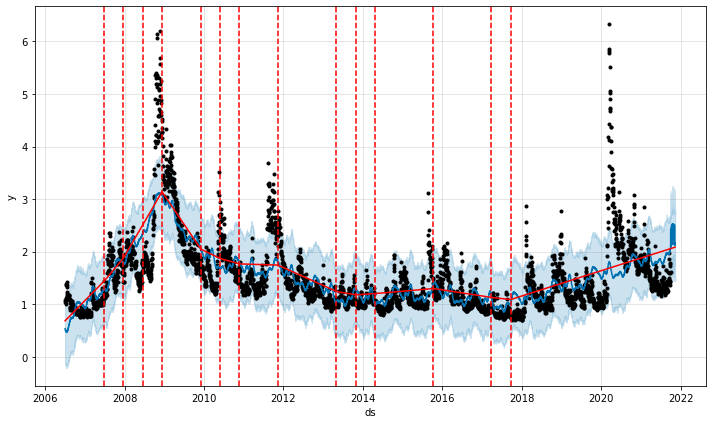

In [27]:
# Plot the Prophet predictions for the forecast_trends data
plot_forecast_trends_cum_prod = model_cum_prod.plot(forecast_trends_cum_prod)

# add change points to plot; by default changepoints are only inferred for the first 80% of data to avoid overfitting,
# but this can be changed by using the changepoint_range argument of the model
a = add_changepoints_to_plot(plot_forecast_trends_cum_prod.gca(),
                             model_cum_prod,
                             forecast_trends_cum_prod,
                             trend=True)

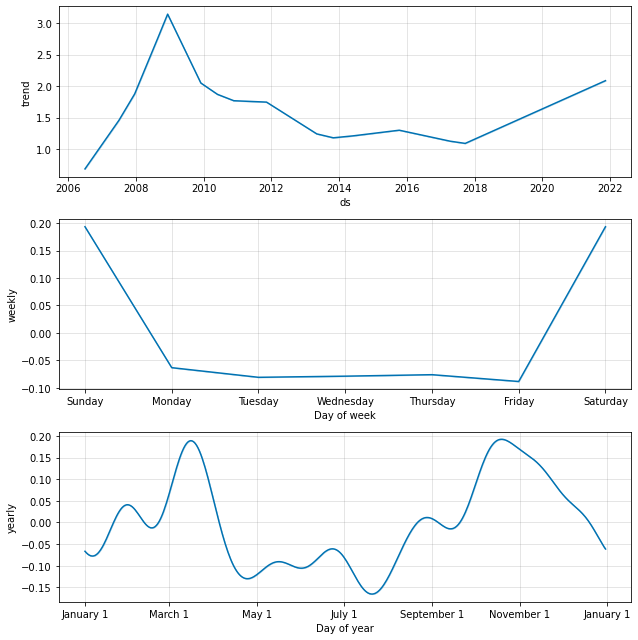

In [28]:
# Use the plot_components function to visualize the forecast results.
figures_cum_prod = model_cum_prod.plot_components(forecast_trends_cum_prod)

In [29]:
vix_data_df = pd.concat((vix_data_df, pd.get_dummies(vix_data_df["ds"].dt.day_name())), axis=1)
vix_data_df.head()

ds         y  Friday  Monday  Thursday  Tuesday  Wednesday
0 2006-07-03       NaN       0       1         0        0          0
1 2006-07-05  0.084291       0       0         0        0          1
2 2006-07-06 -0.035336       0       0         1        0          0
3 2006-07-07  0.023443       1       0         0        0          0
4 2006-07-10  0.003579       0       1         0        0          0

In [30]:
prophet_output_day_of_week = vix_data_df.copy()
prophet_output_day_of_week.columns = ["Date", "y", "Friday", "Monday", "Thursday", "Tuesday", "Wednesday"]
prophet_output_day_of_week.to_csv('prophet_output_day_of_week.csv', index=False)  

In [31]:
vix_data_df = pd.concat((vix_data_df, pd.get_dummies(vix_data_df["ds"].dt.month_name())), axis=1)
vix_data_df.head()

ds         y  Friday  Monday  Thursday  Tuesday  Wednesday  April  \
0 2006-07-03       NaN       0       1         0        0          0      0   
1 2006-07-05  0.084291       0       0         0        0          1      0   
2 2006-07-06 -0.035336       0       0         1        0          0      0   
3 2006-07-07  0.023443       1       0         0        0          0      0   
4 2006-07-10  0.003579       0       1         0        0          0      0   

   August  December  February  January  July  June  March  May  November  \
0       0         0         0        0     1     0      0    0         0   
1       0         0         0        0     1     0      0    0         0   
2       0         0         0        0     1     0      0    0         0   
3       0         0         0        0     1     0      0    0         0   
4       0         0         0        0     1     0      0    0         0   

   October  September  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0

In [32]:
vix_data_df.corr()

y    Friday    Monday  Thursday   Tuesday  Wednesday  \
y          1.000000 -0.065145  0.099858  0.004520 -0.010280  -0.026228   
Friday    -0.065145  1.000000 -0.240799 -0.251628 -0.253863  -0.254269   
Monday     0.099858 -0.240799  1.000000 -0.241973 -0.244122  -0.244513   
Thursday   0.004520 -0.251628 -0.241973  1.000000 -0.255101  -0.255509   
Tuesday   -0.010280 -0.253863 -0.244122 -0.255101  1.000000  -0.257779   
Wednesday -0.026228 -0.254269 -0.244513 -0.255509 -0.257779   1.000000   
April     -0.016263 -0.022581  0.015460  0.004824  0.000325   0.002301   
August     0.013874  0.000243  0.010231 -0.000999 -0.005487  -0.003664   
December   0.000518 -0.004937  0.009165  0.001007 -0.001121  -0.003855   
February   0.010806  0.008215 -0.020623  0.004619  0.002573   0.004652   
January    0.008569  0.008016 -0.027121  0.009260  0.002345   0.006750   
July      -0.006492 -0.004331  0.007661  0.001331 -0.000885  -0.003559   
June       0.007103 -0.000667  0.011186 -0.004185 -0.001643  -0.004361   
March     -0.012067 -0.008125  0.013174  0.000009  0.000155  -0.004859   
May        0.001149  0.008803 -0.022833  0.007612  0.003097   0.002708   
November  -0.016581  0.008940  0.015913 -0.028171  0.000871   0.002872   
October    0.004181  0.000724  0.008026 -0.000477 -0.004956  -0.003057   
September  0.004917  0.006339 -0.022226  0.005135  0.005261   0.004863   

              April    August  December  February   January      July  \
y         -0.016263  0.013874  0.000518  0.010806  0.008569 -0.006492   
Friday    -0.022581  0.000243 -0.004937  0.008215  0.008016 -0.004331   
Monday     0.015460  0.010231  0.009165 -0.020623 -0.027121  0.007661   
Thursday   0.004824 -0.000999  0.001007  0.004619  0.009260  0.001331   
Tuesday    0.000325 -0.005487 -0.001121  0.002573  0.002345 -0.000885   
Wednesday  0.002301 -0.003664 -0.003855  0.004652  0.006750 -0.003559   
April      1.000000 -0.094766 -0.088897 -0.084678 -0.087040 -0.092537   
August    -0.094766  1.000000 -0.095261 -0.090740 -0.093270 -0.099161   
December  -0.088897 -0.095261  1.000000 -0.085121 -0.087494 -0.093021   
February  -0.084678 -0.090740 -0.085121  1.000000 -0.083342 -0.088606   
January   -0.087040 -0.093270 -0.087494 -0.083342  1.000000 -0.091077   
July      -0.092537 -0.099161 -0.093021 -0.088606 -0.091077  1.000000   
June      -0.089816 -0.096246 -0.090286 -0.086001 -0.088399 -0.093982   
March     -0.090729 -0.097224 -0.091203 -0.086875 -0.089297 -0.094938   
May       -0.089051 -0.095425 -0.089516 -0.085268 -0.087645 -0.093181   
November  -0.087507 -0.093770 -0.087964 -0.083789 -0.086125 -0.091565   
October   -0.091636 -0.098196 -0.092115 -0.087743 -0.090190 -0.095887   
September -0.090578 -0.097061 -0.091051 -0.086730 -0.089148 -0.094779   

               June     March       May  November   October  September  
y          0.007103 -0.012067  0.001149 -0.016581  0.004181   0.004917  
Friday    -0.000667 -0.008125  0.008803  0.008940  0.000724   0.006339  
Monday     0.011186  0.013174 -0.022833  0.015913  0.008026  -0.022226  
Thursday  -0.004185  0.000009  0.007612 -0.028171 -0.000477   0.005135  
Tuesday   -0.001643  0.000155  0.003097  0.000871 -0.004956   0.005261  
Wednesday -0.004361 -0.004859  0.002708  0.002872 -0.003057   0.004863  
April     -0.089816 -0.090729 -0.089051 -0.087507 -0.091636  -0.090578  
August    -0.096246 -0.097224 -0.095425 -0.093770 -0.098196  -0.097061  
December  -0.090286 -0.091203 -0.089516 -0.087964 -0.092115  -0.091051  
February  -0.086001 -0.086875 -0.085268 -0.083789 -0.087743  -0.086730  
January   -0.088399 -0.089297 -0.087645 -0.086125 -0.090190  -0.089148  
July      -0.093982 -0.094938 -0.093181 -0.091565 -0.095887  -0.094779  
June       1.000000 -0.092146 -0.090442 -0.088873 -0.093067  -0.091992  
March     -0.092146  1.000000 -0.091361 -0.089776 -0.094013  -0.092927  
May       -0.090442 -0.091361  1.000000 -0.088116 -0.092274  -0.091208  
November  -0.088873 -0.089776 -0.088116  1.000000 -0.09

In [33]:
vix_data_df = vix_data_df.drop(columns=["Tuesday", "Wednesday", "Thursday"])
vix_data_df

ds         y  Friday  Monday  April  August  December  February  \
0    2006-07-03       NaN       0       1      0       0         0         0   
1    2006-07-05  0.084291       0       0      0       0         0         0   
2    2006-07-06 -0.035336       0       0      0       0         0         0   
3    2006-07-07  0.023443       1       0      0       0         0         0   
4    2006-07-10  0.003579       0       1      0       0         0         0   
...         ...       ...     ...     ...    ...     ...       ...       ...   
3835 2021-09-27  0.056901       0       1      0       0         0         0   
3836 2021-09-28  0.239339       0       0      0       0         0         0   
3837 2021-09-29 -0.029677       0       0      0       0         0         0   
3838 2021-09-30  0.025709       0       0      0       0         0         0   
3839 2021-10-01 -0.088159       1       0      0       0         0         0   

      January  July  June  March  May  November  October  September  
0           0     1     0      0    0         0        0          0  
1           0     1     0      0    0         0        0          0  
2           0     1     0      0    0         0        0          0  
3           0     1     0      0    0         0        0          0  
4           0     1     0      0    0         0        0          0  
...       ...   ...   ...    ...  ...       ...      ...        ...  
3835        0     0     0      0    0         0        0          1  
3836        0     0     0      0    0         0        0          1  
3837        0     0     0      0    0         0        0          1  
3838        0     0     0      0    0         0        0          1  
3839        0     0     0      0    0         0        1          0  

[3840 rows x 16 columns]

In [34]:
vix_data_df = vix_data_df.drop(columns=["April", "August", "December", "February", "January", "July", "June", "March", "May", "November", "October", "September"])
vix_data_df

ds         y  Friday  Monday
0    2006-07-03       NaN       0       1
1    2006-07-05  0.084291       0       0
2    2006-07-06 -0.035336       0       0
3    2006-07-07  0.023443       1       0
4    2006-07-10  0.003579       0       1
...         ...       ...     ...     ...
3835 2021-09-27  0.056901       0       1
3836 2021-09-28  0.239339       0       0
3837 2021-09-29 -0.029677       0       0
3838 2021-09-30  0.025709       0       0
3839 2021-10-01 -0.088159       1       0

[3840 rows x 4 columns]

In [35]:
vix_data_df.columns = ["Date", "close", "Friday", "Monday"]
# vix_data_df = vix_data_df.set_index("date")
vix_data_df

Date     close  Friday  Monday
0    2006-07-03       NaN       0       1
1    2006-07-05  0.084291       0       0
2    2006-07-06 -0.035336       0       0
3    2006-07-07  0.023443       1       0
4    2006-07-10  0.003579       0       1
...         ...       ...     ...     ...
3835 2021-09-27  0.056901       0       1
3836 2021-09-28  0.239339       0       0
3837 2021-09-29 -0.029677       0       0
3838 2021-09-30  0.025709       0       0
3839 2021-10-01 -0.088159       1       0

[3840 rows x 4 columns]

In [36]:
vix_data_df.to_csv('prophet_output.csv', index=False)  